In [1]:
import arcpy
import os
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *

# 矢量计算实现

In [ ]:
# 获取要素字段
def get_filed(ele_path):
    """获取输入要素的字段及类型"""
    field_dict = {}
    for one_field in arcpy.ListFields(ele_path):
        field_dict[one_field.name] = one_field.type
    return field_dict
# 获取要素的df表
def get_ele_df(ele_path,field_list):
    """获取输入要素的df表"""
    df = pd.DataFrame(TableToNumPyArray(ele_path,field_list))
    return df


# 按属性选择并导出为要素类
def export_ele_by_attr(in_path, out_path, field_name, field_values):
    """
    按属性选择并导出为要素类，field_values可以是单个值也可以是一个列表

    参数:
    in_path: 输入要素类的路径
    out_path: 输出要素类的路径
    field_name: 用于选择的字段名称
    field_values: 单个字段值或字段值列表，基于这些值进行选择
    """
    # 确保field_values总是列表
    if not isinstance(field_values, list):
        field_values = [field_values]  # 将单个值转换为列表

    # 将输入的要素类转换为图层
    temp_layer = "tempLayer"
    arcpy.MakeFeatureLayer_management(in_path, temp_layer)
    
    # 清除在临时图层上的任何现有选择
    arcpy.SelectLayerByAttribute_management(temp_layer, "CLEAR_SELECTION")
    
    # 构建查询语句以处理值列表
    values_str = ','.join([f"'{value}'" for value in field_values])
    query = f"{field_name} IN ({values_str})"
    
    # 使用查询语句按属性选择
    arcpy.SelectLayerByAttribute_management(temp_layer, "NEW_SELECTION", query)
    
    # 检查是否有选择的要素
    if int(arcpy.GetCount_management(temp_layer)[0]) > 0:
        # 导出选择的要素
        arcpy.CopyFeatures_management(temp_layer, out_path)
        print(f"已成功导出要素到 {out_path}")
    else:
        print("没有找到匹配的要素。")
    
    # 清理临时图层
    arcpy.Delete_management(temp_layer)




In [ ]:
work_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy'
env.workspace = work_path
env.overwriteOutput = True

In [ ]:
arcpy.ListFeatureClasses()

In [ ]:
gtsd_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy\dy_sd'
temp_path = r'D:\ArcGISProjects\workspace\shbyq\soil_type_result.gdb\soiltype_dy\soiltype_prediction_CATB_20240226'

In [ ]:
field_dict = get_filed(gtsd_path)

In [ ]:
field_dict

In [ ]:
df = get_ele_df(gtsd_path,['DLBM','DLMC'])
# 去重
df =df.drop_duplicates()
df

In [ ]:
df = get_ele_df(temp_path,['TL'])
# 去重
df =df.drop_duplicates()
df

In [ ]:
export_ele_by_attr(temp_path,'dy_pre_tl','TL','水稻土')

In [ ]:
export_ele_by_attr('dy_sd','dy_ZRT','DLMC',['茶园','其他园地','乔木林地','竹林地','灌木林地','其他林地','人工牧草地','其他草地'])

# 栅格计算实现

In [1]:
import numpy as np
import arcpy
import pandas as pd
from scipy.spatial import cKDTree
from arcpy import env
import arcpy
import os
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *


In [2]:
def load_raster_as_array(raster_path):
    """
    将栅格数据加载为NumPy数组。
    """
    return arcpy.RasterToNumPyArray(raster_path)

def create_cKDTree_for_replacement(raster, mask, inverse=False):
    """
    根据指定的掩码创建cKDTree，用于快速寻找最近的替代值。
    inverse参数决定是使用掩码(True)还是反掩码(False)中的位置创建树。
    """
    if inverse:
        positions = np.column_stack(np.where(~mask))
    else:
        positions = np.column_stack(np.where(mask))
    return cKDTree(positions), positions
def find_and_replace_with_mapping(pre_raster, dl_raster, mapping, paddy_codes):
    """
    根据dl_raster到pre_raster的映射关系，查找并替换需要调整的像素值。
    """
    corrected_raster = np.copy(pre_raster)
    for dl_code, target_pre_codes in mapping.items():
        # 找到dl_raster中指定dl_code的所有位置
        dl_mask = dl_raster == dl_code
        # 找出这些位置中pre_raster不在目标水田代码列表中的像素
        replace_mask = dl_mask & (~np.isin(pre_raster, target_pre_codes))
        # 对这些需要替换的像素进行处理
        corrected_raster = find_and_replace_nearest(corrected_raster, replace_mask, paddy_codes)
    
    return corrected_raster


def find_and_replace_nearest(target_raster, mask, replacement_codes, inverse=False):
    """
    查找并替换栅格中需要被替代的值。
    """
    corrected_raster = np.copy(target_raster)
    tree, valid_positions = create_cKDTree_for_replacement(target_raster, np.isin(target_raster, replacement_codes), inverse)
    to_be_replaced = np.column_stack(np.where(mask))
    
    if to_be_replaced.size > 0:
        _, nearest_indices = tree.query(to_be_replaced)
        nearest_valid_values = target_raster[valid_positions[nearest_indices][:, 0], valid_positions[nearest_indices][:, 1]]
        corrected_raster[to_be_replaced[:, 0], to_be_replaced[:, 1]] = nearest_valid_values

    return corrected_raster

In [5]:
env.workspace = r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_ky.gdb'

In [6]:
# 示例使用
pre_raster_path = r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_ky.gdb\prediction_soiltype_tz_RFE_20240411'
dl_raster_path = r'D:\ArcGISProjects\workspace\shbyq\feature_raster_file\features_data_ky.gdb\DL'
output_raster_path = "prediction_sioltype_RandomForestEntr_20240411_reclass"

In [22]:
# 获取DL代码对照表
dl_polygon_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_ky\ky_sd'
df_dl_polygon=pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(dl_polygon_path,['DLMC','DLDM']))
# 得到每个DLDM的DLMC
dl_dict = df_dl_polygon.set_index('DLDM')['DLMC'].to_dict()
dl_dict

{1: '旱地',
 2: '农村宅基地',
 3: '乔木林地',
 4: '沟渠',
 5: '农村道路',
 6: '坑塘水面',
 7: '灌木林地',
 8: '竹林地',
 9: '水田',
 10: '设施农用地',
 11: '其他草地',
 12: '其他林地',
 13: '果园',
 14: '公用设施用地',
 15: '其他园地',
 16: '科教文卫用地',
 17: '采矿用地',
 18: '城镇村道路用地',
 19: '茶园',
 20: '商业服务业设施用地',
 21: '公路用地',
 22: '交通服务场站用地',
 23: '水工建筑用地',
 24: '河流水面',
 25: '机关团体新闻出版用地',
 26: '工业用地',
 27: '物流仓储用地',
 28: '特殊用地',
 29: '养殖坑塘',
 30: '城镇住宅用地',
 31: '水库水面',
 32: '裸岩石砾地',
 33: '水浇地',
 34: '管道运输用地',
 35: '内陆滩涂',
 36: '广场用地',
 37: '公园与绿地',
 38: '裸土地',
 39: '铁路用地',
 40: '空闲地',
 41: '港口码头用地'}

In [32]:
# 得到每个土类对应的代码
tl_polygon_path = r'D:\ArcGISProjects\workspace\shbyq\soil_type_result.gdb\soiltype_ky\prediction_sioltype_RandomForestEntr_20240411_reclass_smooth'
df_tl_polygon=pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(tl_polygon_path,['gridcode','TL','YL','TS','TZ']))
# 对每个土类对应的编号生成一个字典
# tl_dict = df_tl_polygon.groupby('TL')['gridcode'].apply(set).to_dict()
tl_dict = df_tl_polygon.groupby('TL')['gridcode'].apply(lambda x: list(set(x))).to_dict()
tl_dict

{'山地黄棕壤': [8, 111, 31],
 '水稻土': [18,
  19,
  20,
  22,
  39,
  41,
  42,
  44,
  48,
  50,
  51,
  53,
  54,
  55,
  56,
  57,
  59,
  64,
  67,
  76,
  78,
  84,
  99,
  102,
  103,
  104,
  105,
  106,
  108,
  109,
  114,
  115,
  119],
 '潮土': [58],
 '石灰土': [96, 1, 0, 36, 37, 38, 68, 40, 43, 46, 15, 16, 118, 23, 86, 24, 95],
 '紫色土': [11, 75, 77, 79, 80, 93],
 '黄壤': [2,
  3,
  4,
  6,
  7,
  13,
  14,
  21,
  25,
  26,
  27,
  29,
  34,
  35,
  45,
  49,
  52,
  60,
  62,
  70,
  71,
  72,
  87,
  89,
  90,
  91,
  94,
  98,
  100,
  107,
  110,
  113]}

In [41]:
# 得到自然土对应的代码
# 使用str.contains来筛选B列中包含特定字符的行
mask = df_tl_polygon['TZ'].str.contains('薄层|中层|厚层', case=False, na=False)

# 获取满足条件的行的A列和B列值，并转换为字典
zr_result = df_tl_polygon[mask].set_index('gridcode')['TZ'].to_dict()

print(zr_result)
# 只输出代码
print(list(zr_result.keys()))

{15: '中层黄色石灰土', 95: '薄层黄色石灰土', 96: '薄层黑色石灰土', 3: '中层硅铁质黄壤', 27: '厚层硅铁质黄壤性土', 94: '薄层铁铝质黄壤', 6: '中层硅铝质黄壤', 26: '厚层硅铁质黄壤', 16: '中层黑色石灰土', 87: '薄层硅质黄壤', 29: '厚层硅铝质黄壤', 36: '厚层黄色石灰土', 37: '厚层黑色石灰土', 91: '薄层硅铝质黄壤', 35: '厚层铁铝质黄壤', 14: '中层铁铝质黄壤', 1: '中层淋溶黄色石灰土', 89: '薄层硅铁质黄壤', 90: '薄层硅铁质黄壤性土', 23: '厚层次生黄色石灰土', 7: '中层硅铝质黄壤性土', 4: '中层硅铁质黄壤性土', 2: '中层硅质黄壤', 11: '中层酸性紫色土', 93: '薄层酸性紫色土', 86: '薄层淋溶黄色石灰土', 8: '中层硅铝质黄棕壤', 25: '厚层硅质黄壤', 31: '厚层硅铝质黄棕壤', 0: '中层次生黄色石灰土', 24: '厚层淋溶黄色石灰土', 13: '中层铁质黄壤', 34: '厚层铁质黄壤'}
[15, 95, 96, 3, 27, 94, 6, 26, 16, 87, 29, 36, 37, 91, 35, 14, 1, 89, 90, 23, 7, 4, 2, 11, 93, 86, 8, 25, 31, 0, 24, 13, 34]


In [42]:
# 定义类别代码
paddy_codes = tl_dict['水稻土']  # 水田代码
natural_soil_codes_dl = list(zr_result.keys())  # dl_raster中自然土代码

# 条件1: dl_raster中标记为水田的像素在pre_raster中也必须是水田代码
# 映射字典
mapping = {
    9: paddy_codes,  # dl_raster中的1对应pre_raster中的所有水田代码 水田
    1: paddy_codes,  # 同上  旱地
    33: paddy_codes,   # 同上 水浇地
    29: paddy_codes   # 同上 养殖坑塘
}

In [43]:
pre_raster = load_raster_as_array(pre_raster_path)
dl_raster= load_raster_as_array(dl_raster_path)

In [44]:
pre_raster.shape, dl_raster.shape

((13978, 11971), (13978, 11971))

In [45]:
# 使用映射字典处理条件1
corrected_raster_condition1 = find_and_replace_with_mapping(pre_raster, dl_raster, mapping, paddy_codes)

# 处理条件2: pre_raster中为水田代码的像素，对应的dl_raster的值不应该在自然土代码列表中
natural_soil_mask_dl = np.isin(dl_raster, natural_soil_codes_dl)  # dl_raster中自然土的掩码
paddy_in_pre = np.isin(pre_raster, paddy_codes)  # pre_raster中水田的掩码
condition2_mask = natural_soil_mask_dl & paddy_in_pre
corrected_raster_condition2 = find_and_replace_nearest(corrected_raster_condition1, condition2_mask, paddy_codes, True)


In [46]:
env.extent = r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_ky.gdb\prediction_soiltype_tz_RFE_20240411'

In [47]:
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster

In [49]:
result_raster = mask_raster(corrected_raster_condition2,r'D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_ky.gdb\prediction_soiltype_tz_RFE_20240411', 5)

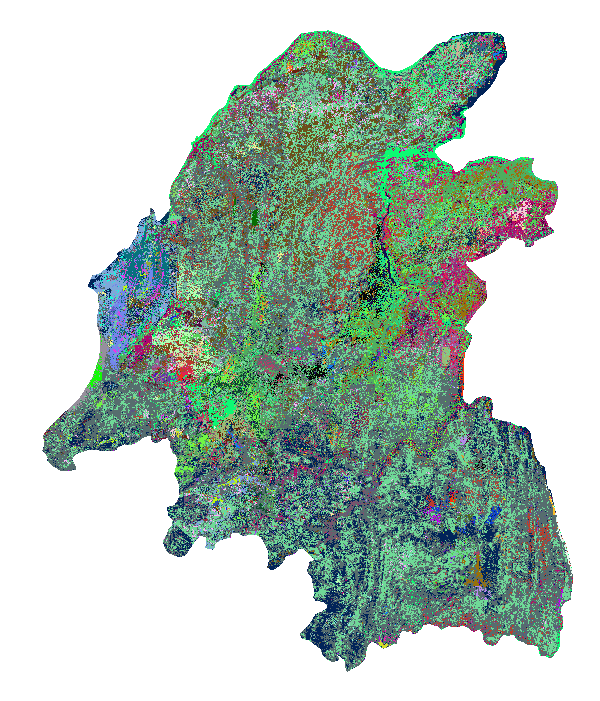

In [50]:
arcpy.sa.Int(result_raster)

In [51]:
result_raster.save(output_raster_path)

In [22]:
point_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_ky\ky_check_point'
dict_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_ky\ky_tl'

In [14]:
# 添加字段
# 添加字段
def add_field(input_table,field_name,field_type='TEXT'):
    """参数说明：
        input_table: 输入数据表
        field_name: 字段名
        field_type: 字段类型"""
    arcpy.AddField_management(input_table,field_name,field_type)
# 增加字段
for one_field in ['TL','YL','TS','TZ']:
    add_field(point_path, one_field, 'TEXT')

In [3]:
df_point = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(dict_path, field_names=['土种代号','TZ','TS','YL','TL']))

In [4]:
# 对每个唯一的土种编号生成一个字典
def aggregate_rows(group):
    records = group[['TL', 'YL', 'TS','TZ']].to_dict('records')
    # 假设每个土种编号下的记录是相同的，这里我们取第一个记录
    return records[0] if records else {}

# 使用groupby按照`土种编号`聚合，并应用自定义函数
soil_dict = df_point.groupby('土种代号').apply(aggregate_rows).to_dict()

In [5]:
soil_dict

{'14a': {'TL': '山地黄棕壤', 'YL': '山地黄壤', 'TS': '硅铁质黄棕壤', 'TZ': '厚层硅铁质黄棕壤'},
 '14b': {'TL': '山地黄棕壤', 'YL': '山地黄壤', 'TS': '硅铁质黄棕壤', 'TZ': '中层硅铁质黄棕壤'},
 '15a': {'TL': '山地黄棕壤', 'YL': '山地黄壤', 'TS': '硅铝质黄棕壤', 'TZ': '厚层硅铝质黄棕壤'},
 '15b': {'TL': '山地黄棕壤', 'YL': '山地黄壤', 'TS': '硅铝质黄棕壤', 'TZ': '中层硅铝质黄棕壤'},
 '172': {'TL': '山地黄棕壤', 'YL': '灰泡土', 'TS': '灰泡土', 'TZ': '灰泡土'},
 '173': {'TL': '山地黄棕壤', 'YL': '灰泡土', 'TS': '灰泡土', 'TZ': '黄灰泡土'},
 '19a': {'TL': '黄壤', 'YL': '黄壤', 'TS': '铁质黄壤', 'TZ': '厚层铁质黄壤'},
 '19b': {'TL': '黄壤', 'YL': '黄壤', 'TS': '铁质黄壤', 'TZ': '中层铁质黄壤'},
 '20a': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅质黄壤', 'TZ': '厚层硅质黄壤'},
 '20b': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅质黄壤', 'TZ': '中层硅质黄壤'},
 '20c': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅质黄壤', 'TZ': '薄层硅质黄壤'},
 '21a': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅铁质黄壤', 'TZ': '厚层硅铁质黄壤'},
 '21b': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅铁质黄壤', 'TZ': '中层硅铁质黄壤'},
 '21c': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅铁质黄壤', 'TZ': '薄层硅铁质黄壤'},
 '22a': {'TL': '黄壤', 'YL': '黄壤', 'TS': '硅铝质黄壤', 'TZ': '厚层硅铝质黄

In [30]:
code_block =f"""
def get_soil_class(soil_code):
    soil_code = str(soil_code).lower()
    soil_dict = {soil_dict}
    TZ = soil_dict[soil_code]['TZ']
    TL = soil_dict[soil_code]['TL']
    YL = soil_dict[soil_code]['YL']
    TS = soil_dict[soil_code]['TS']
    result_list = [TZ,TS,YL,TL]
    return result_list[3]
"""
field_name = 'TL'

In [16]:
expression = "get_soil_class(!代号!)"

In [31]:
# 计算字段
arcpy.CalculateField_management(in_table=point_path, field=field_name, expression=expression, expression_type="PYTHON3", code_block=code_block)
    

<Result 'D:\\ArcGISProjects\\workspace\\shbyq\\features_data_vector.gdb\\features_ky\\ky_check_point'>